In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 24.00it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 2
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:01<00:00, 22646.68it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    closses=0
    flosses=0
    elosses=0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        # reshape decoded_x as N P D dimensions where N is batch size, P is number of points and D is dimension of each point
        # decoded_x = decoded_x.reshape(batch_size, n_neigh+1, 3)
        # reshape data.x as N P D dimensions where N is batch size, P is number of points and D is dimension of each point
        # data.x = data.x.reshape(batch_size, n_neigh+1, 3)
        # calculate chamfer distance between decoded_x and data.x
        # print(decoded_x.shape,data.x.shape)
        # print(decoded_x.device,data.x.device)
        # print(decoded_x.dtype,data.x.dtype)
        # print(decoded_x.requires_grad,data.x.requires_grad)
        # closs=chamfer_distance(decoded_x,data.x)
        # closs=closs[0]
        # loss=closs

        floss=MSE_loss(decoded_x, data.x)
      
        loss=floss
        loss.backward()
        all_loss_mse += float(loss)
      
        # flosses+=float(floss)
        optimizer.step()
        
    return all_loss_mse/len(train_loader)
   

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []
closses=[]
flosses=[]
elosses=[]
if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        # train_loss_mse,closs,floss,eloss = train()
        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        # print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tEdge Loss: {eloss:.4f},\tFace Loss: {floss:.4f}')
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 163651.3404
	Test: 	MSE Loss: 162678.6150
Epoch: 002
	Train:	MSE Loss: 143372.9059
	Test: 	MSE Loss: 142107.4072


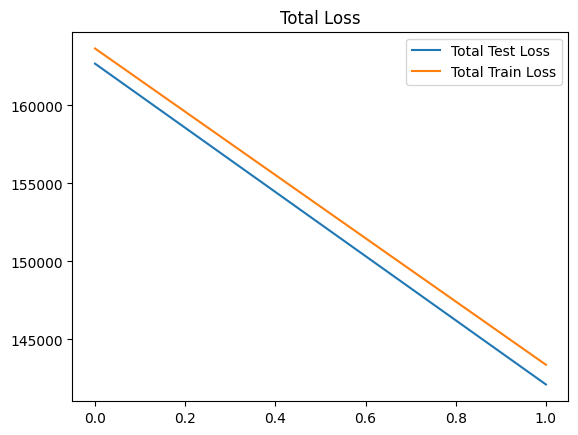

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

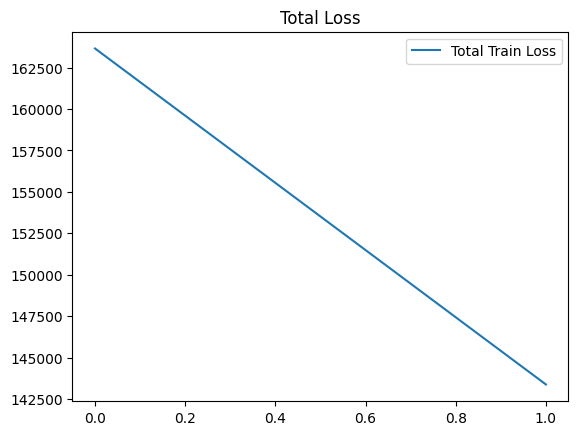

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

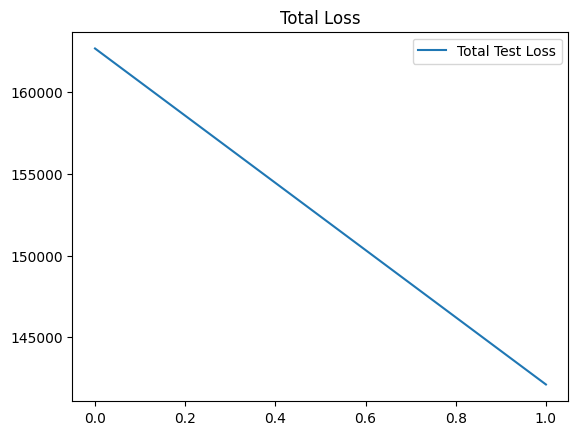

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 142316.98578132156


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [26]:
decoded_feature[0][heavy_indices]

tensor([[173.9350,  -4.3255,  -3.8761,   5.5729,   7.6550,   7.2589],
        [ 79.6270,  -1.9586,  -1.7591,   4.0266,   5.6493,   5.0197],
        [ 82.1531,  -2.0218,  -1.8157,   4.0812,   5.7222,   5.0947],
        [ 82.9613,  -2.0421,  -1.8338,   4.0984,   5.7452,   5.1183],
        [ 78.7763,  -1.9373,  -1.7400,   4.0075,   5.6233,   4.9936],
        [ 83.4813,  -2.0551,  -1.8455,   4.1094,   5.7599,   5.1333],
        [ 83.0341,  -2.0439,  -1.8355,   4.1000,   5.7473,   5.1204],
        [ 85.0818,  -2.0952,  -1.8814,   4.1426,   5.8044,   5.1788],
        [ 83.8013,  -2.0631,  -1.8527,   4.1160,   5.7688,   5.1424],
        [ 80.7806,  -1.9874,  -1.7849,   4.0517,   5.6828,   5.0541],
        [ 79.8032,  -1.9630,  -1.7630,   4.0305,   5.6545,   5.0250],
        [ 81.3219,  -2.0010,  -1.7971,   4.0634,   5.6984,   5.0703],
        [ 82.0756,  -2.0199,  -1.8140,   4.0796,   5.7200,   5.0924],
        [ 80.1700,  -1.9722,  -1.7712,   4.0384,   5.6651,   5.0359],
        [ 85.7824,  

In [27]:
input_feature[0][heavy_indices]

tensor([[ 988.8775, -119.7430, -197.2520,   24.2925,   18.2575,   19.2775],
        [ 988.9932, -119.7824, -197.2340,   22.3050,   19.8000,   20.1000],
        [ 989.9563, -119.8776, -197.4256,   22.7500,   15.9075,   18.3675],
        [ 989.3697, -119.6665, -197.4242,   25.1750,   17.5000,   16.3775],
        [ 987.5820, -119.5613, -197.0431,   23.1675,   22.1200,   18.9500],
        [ 989.3296, -119.7947, -197.3174,   23.0450,   19.8250,   22.8050],
        [ 989.7336, -119.6932, -197.3301,   24.5725,   14.3500,   18.1000],
        [ 989.3072, -119.6944, -197.3076,   22.7650,   19.5025,   15.4400],
        [ 989.8653, -119.8705, -197.3997,   19.9400,   18.9700,   19.7600],
        [ 990.5426, -119.7692, -197.5548,   24.0875,   15.1125,   22.4300],
        [ 988.5647, -119.6835, -197.1300,   25.2675,   21.5200,   22.4975],
        [ 988.2746, -119.4409, -197.1094,   23.8175,   17.4875,   23.9075],
        [ 989.4858, -119.8399, -197.3254,   19.8525,   18.8925,   17.0550],
        [ 98

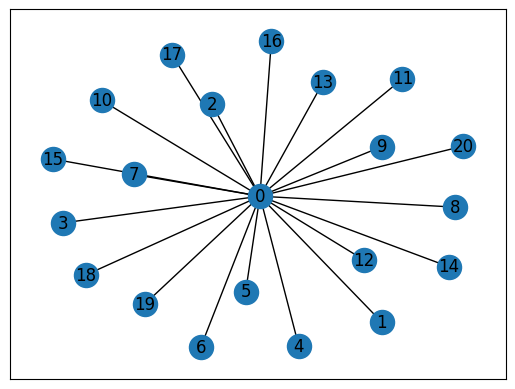

In [28]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [29]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def tryshape():
    m=0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        # chamfer_distance needs shaped N P D
        # N is number of points
        # P is number of points to compare to
        # D is dimension of each point
        # where N is the number of points in the pointcloud = 4*number of atoms
        # P is the number of points to compare to = 4*number of atoms
        # D is the dimension of each point = 3
        # reshape decoded_x
        # print(decoded_x.shape) - [672,6]
        decoded_x = decoded_x.reshape(21,32,6)
        data.x=data.x.reshape(21,32,6)
        closs=chamfer_distance(decoded_x,data.x)
        closs=closs[0]
        loss=closs
        loss.backward()
        all_loss_mse += float(loss)
        # flosses+=float(floss)
        optimizer.step()

        if(m==0):
            # print(data.x)
            print(decoded_x)
            print(f"Data.shape : {data.x.shape}")
            print(f"Decoded.shape : {decoded_x.shape}")
            print(f"Data[0].shape : {data[0].x.shape}")
            print(f"Data[1].shape : {data[1].x.shape}")
            print(f"Data[2].shape : {data[2].x.shape}")
            print(f"Data[3].shape : {data[3].x.shape}")
            print(f"Data[4].shape : {data[4].x.shape}")
            print(f"Data[5].shape : {data[5].x.shape}")
            print(f"Data[6].shape : {data[6].x.shape}")
            print(f"Data[7].shape : {data[7].x.shape}")
            print(f"Data[8].shape : {data[8].x.shape}")
            print(f"Data[21].shape : {data[21].x.shape}")
            
            print(f"Decoded[0].shape : {decoded_x[0].shape}")
        m+=1
    return all_loss_mse/len(train_loader)
    # return all_loss_mse/len(train_loader),closses/len(train_loader),flosses/len(train_loader),elosses/len(train_loader)

In [30]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs*10 + 1):

        # train_loss_mse,closs,floss,eloss = train()
        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        # print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tEdge Loss: {eloss:.4f},\tFace Loss: {floss:.4f}')
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 100852.5271
Epoch: 002
	Train:	MSE Loss: 40261.8950
Epoch: 003
	Train:	MSE Loss: 24377.5934
Epoch: 004
	Train:	MSE Loss: 19111.8673
Epoch: 005
	Train:	MSE Loss: 14363.6201
Epoch: 006
	Train:	MSE Loss: 10308.4128
Epoch: 007
	Train:	MSE Loss: 7327.6435
Epoch: 008
	Train:	MSE Loss: 5740.3094
Epoch: 009
	Train:	MSE Loss: 4842.8318
Epoch: 010
	Train:	MSE Loss: 4023.7085
Epoch: 011
	Train:	MSE Loss: 2879.3705
Epoch: 012
	Train:	MSE Loss: 1461.2549
Epoch: 013
	Train:	MSE Loss: 519.4066
Epoch: 014
	Train:	MSE Loss: 250.8256
Epoch: 015
	Train:	MSE Loss: 145.9298
Epoch: 016
	Train:	MSE Loss: 92.2448
Epoch: 017
	Train:	MSE Loss: 65.1807
Epoch: 018
	Train:	MSE Loss: 49.6096
Epoch: 019
	Train:	MSE Loss: 39.5597
Epoch: 020
	Train:	MSE Loss: 33.2305


In [31]:
tryshape()


RuntimeError: Not compiled with GPU support.